In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from superpoint.models.superpoint_pytorch import SuperPoint
from accelerated_features.modules.xfeat import XFeat
from accelerated_features.modules.lighterglue import LighterGlue
import cv2
import numpy as np

xfeat = XFeat()

/home/navms-pdi2/anaconda3/envs/extractors/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


loading weights from: /home/navms-pdi2/Documentos/lucas-benedetti/01-feature-extraction/accelerated_features/modules/../weights/xfeat.pt


In [2]:
#img_path = "aerial-image.jpeg"
#img_path = "UFRGS-01-2017.png"
#weights_path = "SuperPoint/weights/superpoint_v6_from_tf.pth"
#img = Image.open(img_path).convert("L")
#input = {"image": transforms.ToTensor()(img).unsqueeze(0)} # from (1, H, W) to (1, 1, H, W)

In [3]:
def generate_random_keypoints(
    image_shape,
    num_keypoints,
    device="cpu",
    dtype=torch.float32,
    operation="random"
):
    """
    Gera keypoints de acordo com o tipo de operação especificada.

    Args:
        image_shape: tuple (H, W) ou (B, C, H, W)
        num_keypoints: int, número de keypoints a gerar
        device: str, 'cpu' ou 'cuda'
        dtype: torch.dtype, tipo dos valores
        operation: 
            - "random": gera keypoints aleatórios uniformes (default)
            - tuple ("localized", (x, y), dispersion): gera keypoints próximos a (x, y)
              com dispersão gaussiana (desvio padrão = dispersion)

    Returns:
        torch.Tensor (B, num_keypoints, 2): coordenadas (x, y)
    """
    # Extrai H e W mesmo que venha de shape 4D
    if len(image_shape) == 4:
        _, _, H, W = image_shape
        B = image_shape[0]
    elif len(image_shape) == 2:
        H, W = image_shape
        B = 1
    else:
        raise ValueError("image_shape deve ser (H, W) ou (B, C, H, W).")

    # Caso 1: operação aleatória uniforme
    if operation == "random":
        xs = torch.rand((B, num_keypoints, 1), device=device, dtype=dtype) * (W - 1)
        ys = torch.rand((B, num_keypoints, 1), device=device, dtype=dtype) * (H - 1)

    # Caso 2: operação localizada em torno de (x, y)
    elif isinstance(operation, tuple) and len(operation) == 3 and operation[0] == "localized":
        _, center, dispersion = operation
        cx, cy = center

        # Cria ruído gaussiano ao redor do centro
        xs = torch.normal(mean=cx, std=dispersion, size=(B, num_keypoints, 1),
                          device=device, dtype=dtype)
        ys = torch.normal(mean=cy, std=dispersion, size=(B, num_keypoints, 1),
                          device=device, dtype=dtype)

        # Clampa coordenadas para ficarem dentro da imagem
        xs = xs.clamp(0, W - 1)
        ys = ys.clamp(0, H - 1)

    else:
        raise ValueError(
            "operation deve ser 'random' ou ('localized', (x, y), dispersion)"
        )

    keypoints = torch.cat([xs, ys], dim=-1)
    return keypoints


[] []


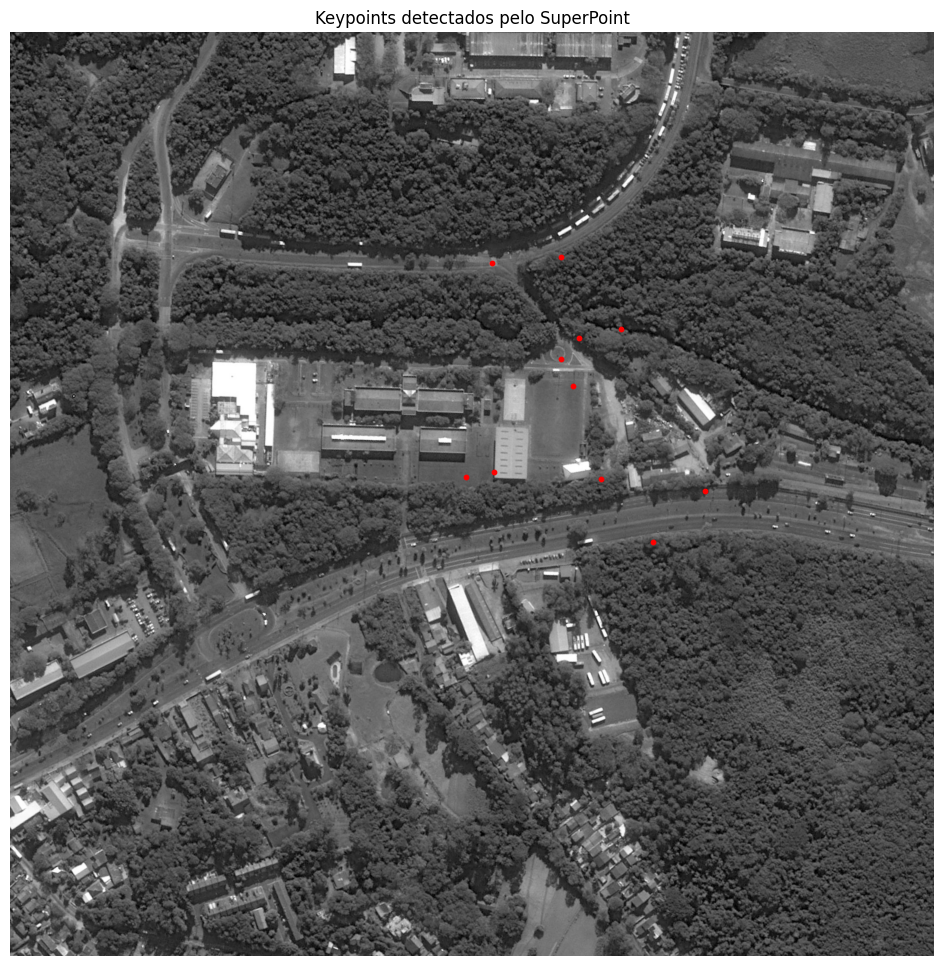

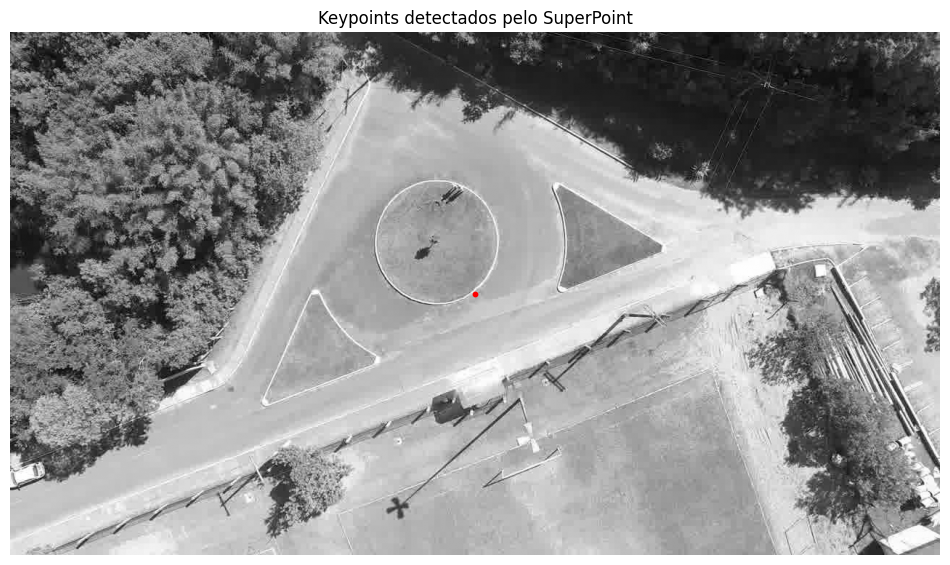

In [62]:
scene_img = Image.open('UFRGS-01-2017.png').convert("L")
scene_input = {"image": transforms.ToTensor()(scene_img).unsqueeze(0)} 

reference_img = Image.open('009-align.jpg').convert("L")
reference_input = {"image": transforms.ToTensor()(reference_img).unsqueeze(0)} 

particles_kpts = generate_random_keypoints((4800, 4800), num_keypoints=10, operation=("localized", (2860, 1700), 500), device="cuda")
gt_kpt = torch.tensor([[[2860, 1700]]], device='cuda:0')
particles_kpts = torch.cat((particles_kpts, gt_kpt), dim=1)

feats0 = xfeat.computeAtKeypoints(scene_input["image"], particles_kpts)[0]
feats1 = xfeat.detectAndCompute(reference_input["image"], top_k = 1)[0]

desc = xfeat.computeGlobalDescriptor(reference_input["image"])[0]
h, w = reference_input['image'].shape[2:]
keypoints_desc = torch.tensor([[w/2,h/2]])

feats0.update({'image_size': (scene_input['image'][0][0].shape[1], scene_input['image'][0][0].shape[0])})
feats1.update({'image_size': (reference_input["image"][0][0].shape[1], reference_input["image"][0][0].shape[0])})
desc.update({'image_size': (keypoints_desc[0][0], keypoints_desc[0][1])})

#Update with image resolution (required)
mkpts_0, mkpts_1, _, output = xfeat.match_lighterglue(feats0, desc)
print(mkpts_0, mkpts_1)

keypoints = particles_kpts[0]
if keypoints is not None:
    keypoints = keypoints.detach().cpu().numpy()  # [N,2]
    plt.figure(figsize=(12,12))
    plt.imshow(scene_img, cmap="gray")
    plt.scatter(keypoints[:,0], keypoints[:,1], c='r', s=10)  # x,y
    plt.title("Keypoints detectados pelo SuperPoint")
    plt.axis("off")
    plt.show()
else:
    print("A saída não contém 'keypoints'")

keypoints = keypoints_desc
if keypoints is not None:
    keypoints = keypoints.detach().cpu().numpy()  # [N,2]
    plt.figure(figsize=(12,12))
    plt.imshow(reference_img, cmap="gray")
    plt.scatter(keypoints[:,0], keypoints[:,1], c='r', s=10)  # x,y
    plt.title("Keypoints detectados pelo SuperPoint")
    plt.axis("off")
    plt.show()
else:
    print("A saída não contém 'keypoints'")

In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_receptive_field(img, keypoint, rf_size=421, stride=32, color='lime', linewidth=2):
    """
    Plota o campo receptivo aproximado do XFeat centrado em um keypoint.

    Args:
        img (np.ndarray): imagem (H, W, 3) ou (H, W)
        keypoint (tuple): (x, y) na imagem original
        rf_size (int): tamanho do campo receptivo (em pixels)
        stride (int): stride acumulado da rede
    """
    import numpy as np

    # Converte tensor para numpy e remove dimensões extras
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
    if img.ndim == 4:  # (B, C, H, W)
        img = img[0]   # remove batch
    if img.ndim == 3 and img.shape[0] == 1:  # (1, H, W) -> (H, W)
        img = img[0]
    elif img.ndim == 3 and img.shape[0] == 3:  # (3, H, W) -> (H, W, 3)
        img = np.transpose(img, (1, 2, 0))

    H, W = img.shape[:2]
    cx, cy = keypoint

    # Define bordas do campo receptivo
    half_rf = rf_size // 2
    x0 = max(cx - half_rf, 0)
    y0 = max(cy - half_rf, 0)
    x1 = min(cx + half_rf, W)
    y1 = min(cy + half_rf, H)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)

    # Retângulo do campo receptivo
    rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0,
                             linewidth=linewidth, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

    # Keypoint central
    ax.scatter(cx, cy, s=50, c='red', marker='x', label='Centro (keypoint)')

    ax.set_title(f"Campo Receptivo ({rf_size} px) centrado em ({cx}, {cy})")
    ax.legend()
    plt.show()


In [75]:
similarities = F.cosine_similarity(desc['descriptors'], feats0['descriptors'], dim=-1)


In [79]:
for e,s in enumerate(similarities):
    print(e,s,feats0['keypoints'][e].tolist())



0 tensor(0.6899, device='cuda:0') [3607.76025390625, 2386.178466796875]
1 tensor(0.5271, device='cuda:0') [3071.77392578125, 2319.5771484375]
2 tensor(0.6087, device='cuda:0') [3174.82373046875, 1540.389404296875]
3 tensor(0.6165, device='cuda:0') [2501.84375, 1198.37646484375]
4 tensor(0.4680, device='cuda:0') [2366.972412109375, 2312.340576171875]
5 tensor(0.5287, device='cuda:0') [2861.567626953125, 1166.5567626953125]
6 tensor(0.5829, device='cuda:0') [2515.579833984375, 2282.90966796875]
7 tensor(0.6633, device='cuda:0') [2956.8125, 1591.6002197265625]
8 tensor(0.5875, device='cuda:0') [3341.177490234375, 2646.946533203125]
9 tensor(0.6026, device='cuda:0') [2924.111328125, 1840.953125]
10 tensor(0.5905, device='cuda:0') [2860.0, 1700.0]


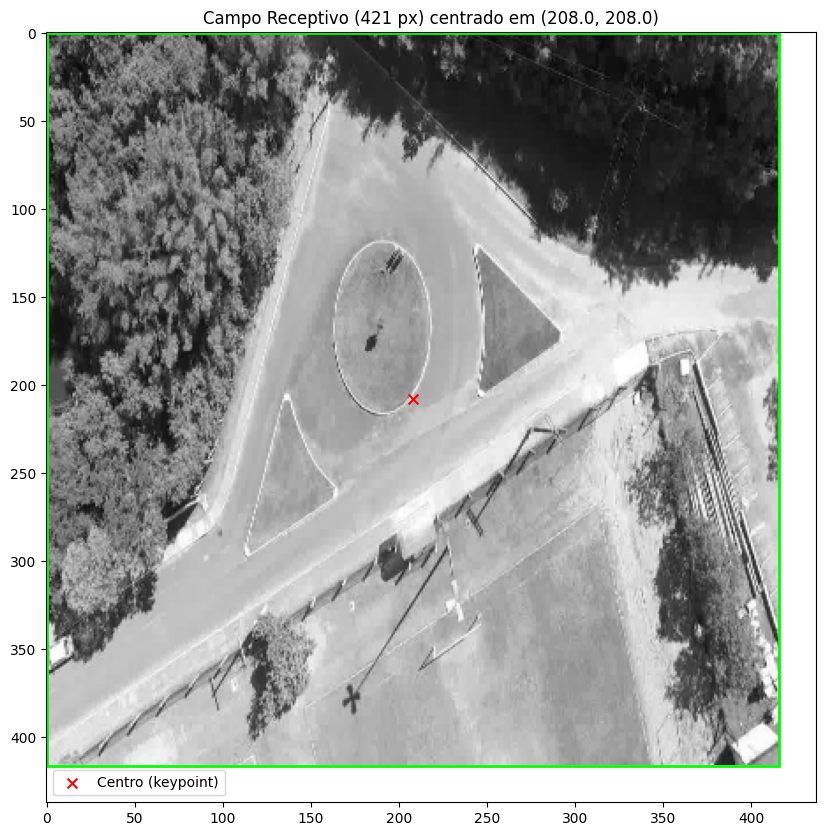

In [66]:
#2853 1681
keypoint = desc['keypoints'][0].cpu().numpy()  # centro da imagem 1280x704

nadir = xfeat.x_receptive
plot_receptive_field(nadir, keypoint, rf_size=421, stride=32)

[3607.7603 2386.1785]


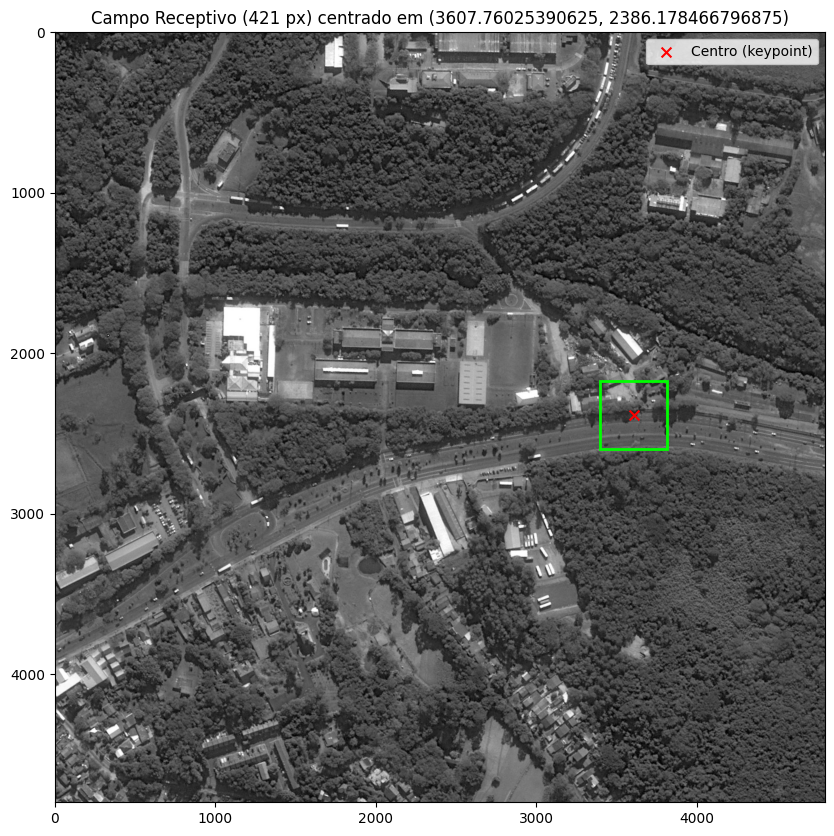

In [67]:
#2853 1681
keypoint = feats0['keypoints'][0].cpu().numpy()  # centro da imagem 1280x704
print(keypoint)
nadir = xfeat.x_receptive
plot_receptive_field(scene_input['image'], keypoint, rf_size=421, stride=32)

torch.Size([720, 1280])

In [63]:
def compute_receptive_field(model, input_size):
    """
    Calcula o campo receptivo efetivo de cada camada Conv2d da rede.
    
    Args:
        model (nn.Module): modelo PyTorch
        input_size (tuple): (B, C, H, W)
    
    Returns:
        list of dicts com nome, RF, stride acumulado e tamanho de saída
    """
    rf = 1      # campo receptivo inicial
    j = 1       # jump (passo)
    start = 0   # offset (pode ser usado pra coordenadas absolutas)
    
    info = []
    hooks = []

    def hook_fn(module, inp, out):
        nonlocal rf, j, start
        if isinstance(module, nn.Conv2d):
            k = module.kernel_size[0]
            s = module.stride[0]
            p = module.padding[0]
            d = module.dilation[0]
            
            rf = rf + ( (k - 1) * d ) * j
            start = start + ((k - 1)/2 - p) * j
            j = j * s

            info.append({
                "layer": module.__class__.__name__,
                "kernel": k,
                "stride": s,
                "padding": p,
                "rf": rf,
                "jump": j,
                "output_shape": tuple(out.shape)
            })

    # registrar hooks
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            hooks.append(m.register_forward_hook(hook_fn))
    
    x = torch.zeros(input_size)
    model.eval()
    with torch.no_grad():
        xfeat.detectAndCompute(x, top_k = 1)
    
    # remover hooks
    for h in hooks:
        h.remove()
    
    return info

In [ ]:
rf_info = compute_receptive_field(xfeat, input_size=transforms.ToTensor()(reference_img).unsqueeze(0).shape)

for i, layer in enumerate(rf_info):
    print(f"{i:02d} | {layer['layer']:<10} | RF={layer['rf']:>3} | Jump={layer['jump']:>2} | Out={layer['output_shape']}")

In [68]:
import cv2
import numpy as np

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    img1 = img1.numpy()
    img2 = img2.numpy()
    # Converter para uint8 se necessário
    if img1.dtype == np.float32:
        img1 = (img1 * 255).astype(np.uint8)
    if img2.dtype == np.float32:
        img2 = (img2 * 255).astype(np.uint8)
    

    # Calcular homografia
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.RANSAC, 5.0)
    if H is None:
        raise ValueError(f"Homografia não pôde ser estimada. Verifique os pontos de entrada.")

    # Criar keypoints a partir das correspondências
    keypoints1 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(float(p[0]), float(p[1]), 1) for p in dst_points]

    # Projetar os cantos da imagem 1 sobre a imagem 2
    h, w = img1.shape[:2]
    corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    warped_corners = cv2.perspectiveTransform(corners, H)

    # Desenhar os cantos projetados sobre a imagem 2
    img2_with_corners = cv2.polylines(img2.copy(), [np.int32(warped_corners)], True, (255, 0, 0), 3)

    # Criar correspondências válidas
    matches = [cv2.DMatch(i, i, 0) for i in range(len(mask)) if mask[i]]

    # Desenhar as correspondências
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                matchColor=(0, 255, 0), flags=2)

    return img_matches


canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, scene_input['image'][0][0], reference_input["image"][0][0])
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

error: OpenCV(4.10.0) /io/opencv/modules/calib3d/src/fundam.cpp:390: error: (-28:Unknown error code -28) The input arrays should have at least 4 corresponding point sets to calculate Homography in function 'findHomography'


In [69]:

matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)



NameError: name 'matcher' is not defined

In [ ]:
#hist_np = np.array(hist)
#print(f"extract 50.0000 particles points view using xfeat: {hist_np.mean():.3f} ± {hist_np.std():.4f} ms")


extract 50.0000 particles points view using xfeat: 0.083 ± 0.0006 ms

